# Objective


Machine learning from data and recommend best TV shows and movies to users based on their own rating history&viewing behaviour patterns

In [1]:
# to import all the library and modules we need 

In [1]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
sns.set_style("darkgrid")

In [1]:
#Surprise is a Python scikit for building and analyzing recommender systems that deal with explicit rating data
#
# !pip install scikit-surprise

  Using cached scikit_surprise-1.1.1-cp37-cp37m-win_amd64.whl


In [2]:
# read dataframe and skip date
df1 = pd.read_csv('../Resources/combined_data_1.txt', header = None, names = ['Customer_Id', 'Rating'], usecols = [0,1])

df1['Rating'] = df1['Rating'].astype(float)

print(f'Dataset 1 shape: {df1.shape}')
print('-Dataset examples-')
print(df1.iloc[::2000000, :])

Dataset 1 shape: (24058263, 2)
-Dataset examples-
         Customer_Id  Rating
0                 1:     NaN
2000000      1910904     5.0
4000000       496631     3.0
6000000      1091776     4.0
8000000      1177065     2.0
10000000     2271935     2.0
12000000      700005     2.0
14000000     1947241     5.0
16000000      956220     4.0
18000000      460528     3.0
20000000     1933327     3.0
22000000     1878057     3.0
24000000      517002     4.0


In [3]:
df2 = pd.read_csv('../Resources/combined_data_2.txt', header = None, names = ['Customer_Id', 'Rating'], usecols = [0,1])

df2['Rating'] = df2['Rating'].astype(float)

df3 = pd.read_csv('../Resources/combined_data_3.txt', header = None, names = ['Customer_Id', 'Rating'], usecols = [0,1])

df3['Rating'] = df3['Rating'].astype(float)

df4 = pd.read_csv('../Resources/combined_data_4.txt', header = None, names = ['Customer_Id', 'Rating'], usecols = [0,1])

df4['Rating'] = df4['Rating'].astype(float)





In [4]:
movie_count=df1['Rating'].isnull().sum()
movie_count

4499

In [5]:
df1_new = df1.dropna()
df1_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24053764 entries, 1 to 24058262
Data columns (total 2 columns):
Customer_Id    object
Rating         float64
dtypes: float64(1), object(1)
memory usage: 550.5+ MB


In [6]:
# df2 = pd.read_csv('../Resources/combined_data_2.txt', header = None, names = ['Customer_Id', 'Rating'], usecols = [0,1])
# df3 = pd.read_csv('../Resources/combined_data_3.txt', header = None, names = ['Customer_Id', 'Rating'], usecols = [0,1])
# df4 = pd.read_csv('../Resources/combined_data_4.txt', header = None, names = ['Customer_Id', 'Rating'], usecols = [0,1])


# df2['Rating'] = df2['Rating'].astype(float)
# df3['Rating'] = df3['Rating'].astype(float)
# df4['Rating'] = df4['Rating'].astype(float)

# print(f'Dataset 2 shape: {df2.shape}')
# print(f'Dataset 3 shape: {df3.shape}')
# print(f'Dataset 4 shape: {df4.shape}')

In [9]:
df_full = pd.concat([df1,df2,df3,df4],axis=0)
df_full.index = np.arange(0,len(df_full))
print(f'Full dataset shape: {df_full.shape}')
print('-Dataset examples-')

print(df_full.iloc[::10000000, :])

Full dataset shape: (100498277, 2)
-Dataset examples-
          Customer_Id  Rating
0                  1:     NaN
10000000      2271935     2.0
20000000      1933327     3.0
30000000       961023     4.0
40000000       854274     5.0
50000000       768483     3.0
60000000      1609324     2.0
70000000      1776418     4.0
80000000       932047     4.0
90000000       932191     4.0
100000000      872339     4.0


In [10]:
df1_new = df1.dropna()
df1_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24053764 entries, 1 to 24058262
Data columns (total 2 columns):
Customer_Id    object
Rating         float64
dtypes: float64(1), object(1)
memory usage: 550.5+ MB


In [11]:
movie_count=df_full['Rating'].isnull().sum()
movie_count

17770

In [12]:
df_full_new = df_full.dropna()
df_full_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100480507 entries, 1 to 100498276
Data columns (total 2 columns):
Customer_Id    object
Rating         float64
dtypes: float64(1), object(1)
memory usage: 2.2+ GB


## Exploratory Data Analysis

### first of all, let us visualise the dataset, a pic says more than millions data here!

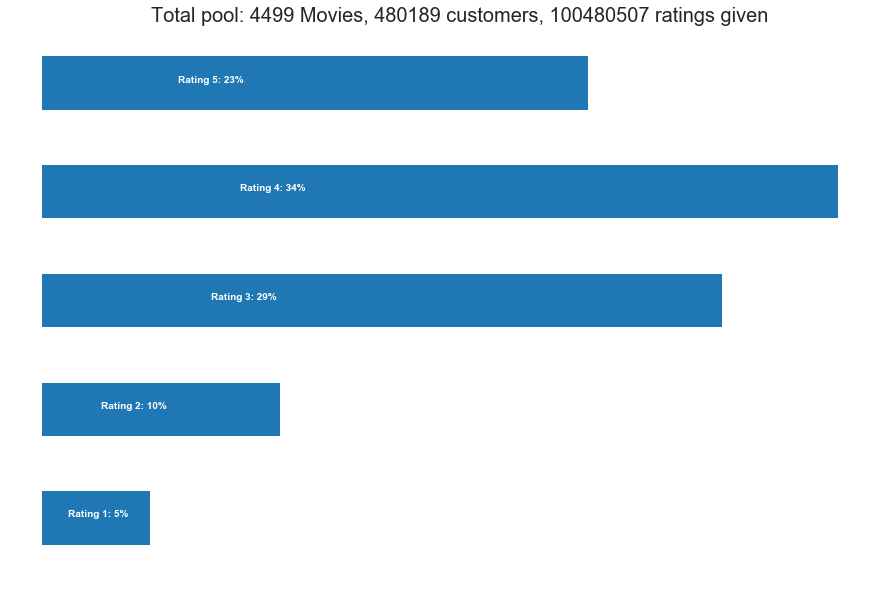

In [13]:
p = df_full_new.groupby('Rating')['Rating'].agg(['count'])
# print(p)
# get movie count
# movie_count = df1.isnull().sum()[1]
# print(movie_count)
# # get customer count
cust_count = len(set(df_full_new['Customer_Id']))
# print(cust_count)
# # get rating count
rating_count = df_full_new['Customer_Id'].count()
ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title(f'Total pool: {movie_count} Movies, {cust_count} customers, {rating_count} ratings given', fontsize=20)
plt.axis('off')
# plt.bar(p.index,p.count)

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold') # TUTOR TO EXPLAIN

it is noted that most of the viewers left ratings tend to think positively about the movies or TV shows. This might due to that happy viewers tend to finish watching the show and leave comments while unhappy viewers tend to switch to watch something else of just leave instead finishing watching.


## Data cleaning

In [13]:
df_nan = pd.DataFrame(pd.isnull(df1.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):         # WHAT ????
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(df1) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]
Length: 24053764


In [12]:
# df1=pd.read_csv("../Resources/combined_data_1.txt",header=None, names=["Cust_Id","Rating"], usecols=[0,1])
# df1["MovieId"]="NaN"
# df3=df1[df1["Cust_Id"].apply(lambda x:x[-1]==":")]
# df3["MovieId"]=df3["Cust_Id"].str.replace(":","")
# df1.loc[df3.index,:]=df3
# df1["MovieId"]=df1["MovieId"].fillna(method="ffill")
# df1=df1[df1["Rating"].notnull()]
# df1

D:\RW_Programs\Anaconda\envs\dev\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Cust_Id,Rating,MovieId
1,1488844,3.0,NaN
2,822109,5.0,NaN
3,885013,4.0,NaN
4,30878,4.0,NaN
5,823519,3.0,NaN
...,...,...,...
24058258,2591364,2.0,NaN
24058259,1791000,2.0,NaN
24058260,512536,5.0,NaN
24058261,988963,3.0,NaN


In [14]:
# df_nan = pd.DataFrame(pd.isnull(df_full.Rating))
# df_nan = df_nan[df_nan['Rating']==True]
# df_nan = df_nan.reset_index()
# df_nan.head()

In [15]:
# df_nan['index'][:-1]

In [16]:
# remove those Movie ID rows
df1 = df1[pd.notnull(df1['Rating'])]

df1['Movie_Id'] = movie_np.astype(int)
df1['Customer_Id'] = df1['Customer_Id'].astype(int)
print('-Dataset examples-')
print(df1.iloc[::5000000, :])

-Dataset examples-
          Customer_Id  Rating  Movie_Id
1             1488844     3.0         1
5000996        501954     2.0       996
10001962       404654     5.0      1962
15002876       886608     2.0      2876
20003825      1193835     2.0      3825


In [17]:
df1.shape

(24053764, 3)

## to reduce the data volumn by improving the data quality below:

Remove movie with too less reviews (they are relatively not popular)
Remove customer who give too less reviews (they are relatively less active)
Having above benchmark will have significant improvement on efficiency, since those unpopular movies and non-active customers still occupy same volumn as those popular movies and active customers in the view of matrix

In [23]:
f = ['count','mean']

df_movie_summary = df1.groupby('Movie_Id')['Rating'].agg(f) # to aggregate movie_id ratings by count and mean
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0) # to set up benchmark for viewers rating counts
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df1.groupby('Customer_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 1799.0
Customer minimum times of review: 52.0


In [20]:
# df_movie_summary=df1.groupby('Movie_Id')['Rating'].agg(['count','mean'])
# df_movie_summary.head()
# # df_movie_summary.index = df_movie_summary.index.map(int)
# df_movie_summary.sample(5)

,count,mean
Movie_Id,,
2721,310,2.358065
2587,78,2.641026
2692,1089,4.015611
931,1809,3.054174
4039,393,1.933842


In [21]:
# df_movie_summary.index.map(int)

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            4490, 4491, 4492, 4493, 4494, 4495, 4496, 4497, 4498, 4499],
           dtype='int64', name='Movie_Id', length=4499)

In [22]:
# movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
# movie_benchmark

1799.0

In [23]:
# df_cust_summary = df1.groupby('Customer_Id')['Rating'].agg(f)
# df_cust_summary.tail()

,count,mean
Customer_Id,,
2649404,12,4.083333
2649409,10,4.000000
2649421,3,5.000000
2649426,74,4.067568
2649429,62,4.161290


### Trim down dataset by benchmark set

In [11]:
print('Original Shape: {}'.format(df1.shape))
df1 = df1[~df1['Movie_Id'].isin(drop_movie_list)]
df1 = df1[~df1['Customer_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df1.shape))
print('-Data Examples-')
print(df1.iloc[::5000000, :])

Original Shape: (24053764, 3)


MemoryError: Unable to allocate 184. MiB for an array with shape (24053764,) and data type int64

In [ ]:
df_p = pd.pivot_table(df1,values='Rating',index='Customer_Id',columns='Movie_Id')

print(df_p.shape)

## Data Mapping

In [20]:
# to load teh movie title dataset
df_title = pd.read_csv('../Resources/movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace = True)
# df_title['Year']=df_title['Year'].astype(int)
df_title.info()
df_title.sample(5)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 17770 entries, 1 to 17770
Data columns (total 2 columns):
Year    17763 non-null float64
Name    17770 non-null object
dtypes: float64(1), object(1)
memory usage: 416.5+ KB


,Year,Name
Movie_Id,,
595,2001.0,Monarch of the Glen: Series 2
9252,2004.0,Jancis Robinson's Wine Course
1932,1996.0,Race the Sun
13453,1994.0,Queen Margot
6431,2000.0,Blood Surf


# Recommedation Models

### Recommend with Collaborative Filtering



In [18]:
#Evalute performance of collaborative filtering, with just first 5K rows for faster process:

reader = Reader()

# get just top 5K rows for faster run time
data = Dataset.load_from_df(df1[['Customer_Id', 'Movie_Id', 'Rating']].iloc[:5000], reader)
#data.split(n_folds=3)

svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])


{'test_rmse': array([1.14829791, 1.14308207, 1.14200074, 1.14279003, 1.11749529]),
 'test_mae': array([0.90505458, 0.90758728, 0.89708449, 0.9213361 , 0.88217996]),
 'fit_time': (0.17410659790039062,
  0.17620182037353516,
  0.1851062774658203,
  0.17400026321411133,
  0.18108487129211426),
 'test_time': (0.005010128021240234,
  0.002995729446411133,
  0.003999948501586914,
  0.003999948501586914,
  0.003996849060058594)}

### Let us predict which movies user 712664 would love to watch:

In [21]:
# to sample one customer's viewing history
df_712664 = df1[(df1['Customer_Id'] == 712664) & (df1['Rating'] == 5)]
df_712664 = df_712664.set_index('Movie_Id')
df_712664 = df_712664.join(df_title)['Name']
print(df_712664)

Movie_Id
3                                   Character
79                                The Killing
175                            Reservoir Dogs
199                           The Deer Hunter
241                        North by Northwest
256         Ghost Dog: The Way of the Samurai
261                             The Big Clock
348             The Last Temptation of Christ
357                     House of Sand and Fog
416                                  Elephant
442                       Mississippi Burning
457                         Kill Bill: Vol. 2
501                  Three Days of the Condor
561                              High and Low
571                           American Beauty
708                         The Perfect Storm
733                              Dead Ringers
788                                    Clerks
798                                      Jaws
872                             Seven Samurai
996                                   Yojimbo
1032                     

In [32]:
user_712664  = df_title.copy()
user_712664  = user_712664 .reset_index()
user_712664  = user_712664 [~user_712664 ['Movie_Id'].isin(drop_movie_list)]

# getting full dataset , Evalute performance of collaborative filtering, with just first 1million rows for faster process:
data = Dataset.load_from_df(df1[['Customer_Id', 'Movie_Id', 'Rating']].iloc[:1000000], reader)

trainset = data.build_full_trainset()
svd.fit(trainset)

user_712664 ['Estimate_Score'] = user_712664 ['Movie_Id'].apply(lambda x: svd.predict(712664 , x).est)

user_712664  = user_712664 .drop('Movie_Id', axis = 1)

user_712664  = user_712664 .sort_values('Estimate_Score', ascending=False)
print(user_712664 .head(10))

       Year                            Name  Estimate_Score
78   1956.0                     The Killing        4.644941
198  1978.0                 The Deer Hunter        4.505028
166  2004.0                      The Chorus        4.326143
32   2000.0  Aqua Teen Hunger Force: Vol. 1        4.230806
67   2004.0                     Invader Zim        4.186279
2    1997.0                       Character        4.127155
51   2002.0         The Weather Underground        4.089440
96   2002.0                   Mostly Martha        4.078450
190  2003.0                X2: X-Men United        4.067398
151  1995.0               A Little Princess        4.056710


### Recommend with Pearsons' R correlations

In [19]:
'''The way it works is we use # Pearsons' R correlation to measure the linear correlation between review scores of all pairs of movies
then we provide the top 10 movies with highest correlations:'''

def recommend(movie_title, min_count):
    print("For movie ({})".format(movie_title))
    print("- Top 10 movies recommended based on Pearsons'R correlation - ")
    i = int(df_title.index[df_title['Name'] == movie_title][0])
    target = df_p[i]
    similar_to_target = df_p.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(df_title).join(df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]
    print(corr_target[corr_target['count']>min_count][:10].to_string(index=False))

### A recommendation for you if you like ?????'

In [24]:
recommend("Justice League", 0)

For movie (Justice League)
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                                               Name  count      mean
 1.000000                                     Justice League   3591  3.710944
 0.775745                   Justice League: Justice on Trial   2961  3.718001
 0.658475                                       Regular Guys   1931  3.372864
 0.654393                                       Testosterone   1951  2.893901
 0.643469  Batman: The Animated Series: Tales of the Dark...   2432  3.583059
 0.631749                           Batman Beyond: The Movie   2614  3.726855
 0.614198                 Batman Beyond: Return of the Joker   3704  3.604752
 0.577765                       Batman: Mask of the Phantasm   2823  3.767977
 0.567673                                 Nine Dead Gay Guys   2064  3.026647
 0.567410                                              Yi Yi   2255  3.328603


In [55]:
recommend("The Lord of the Rings", 0)

For movie (The Lord of the Rings)
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                                         Name  count      mean
 1.000000                        The Lord of the Rings   4729  3.475999
 0.475312                                    Mr. Magoo   1994  2.546138
 0.452681                        Hellraiser V: Inferno   2543  3.179316
 0.446765                  The Hunchback of Notre Dame   1883  3.482209
 0.443695         Scooby-Doo and the Monster of Mexico   2284  3.719352
 0.440859                                    The Quest   2406  3.055278
 0.436077          The Apple Dumpling Gang Rides Again   3160  3.713291
 0.431222                                     18 Again   2266  2.803619
 0.428003           Journey to the Center of the Earth   2013  3.105315
 0.427612  101 Dalmatians II: Patch's London Adventure   6642  3.546070


In [29]:
recommend("The Love Letter",0)

For movie (The Love Letter)
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                                               Name  count      mean
 1.000000                                    The Love Letter   2619  2.968690
 0.612243                              Escaflowne: The Movie   1992  3.629016
 0.606778             Tenchi the Movie: Tenchi Muyo! In Love   2148  3.457635
 0.593931                                          The Quest   2406  3.055278
 0.587133                                     The Desert Fox   1873  3.686065
 0.581241                                       Judgment Day   2085  2.964988
 0.580241                                  Sink the Bismarck   2135  3.706323
 0.578270                                              11:14   2563  3.225127
 0.574225                                  Operation Pacific   1839  3.762915
 0.573812  Mystery Science Theater 3000: The Wild World o...   1907  3.486104
